# Andrew Yang's Freedom Dividend

Estimate the effect of Andrew Yang's [Freedom Dividend](https://www.yang2020.com/policies/the-freedom-dividend/) of $12,000 per year per adult over age 18, funded by a 10 percent [value-added tax](https://www.yang2020.com/policies/value-added-tax/) and reducing benefits by up to the UBI amount for each tax unit.

Assumptions:
* Adults are 18+ not 19+, for data availability.
* Benefits include Social Security, SNAP, WIC, SSI, TANF, WIC, housing benefits, and "other benefits" included in C-TAM. It does not include Medicare, Medicaid, or veteran's benefits.
* VAT incidence is proportional to [Tax Policy Center's estimate](https://www.taxpolicycenter.org/briefing-book/who-would-bear-burden-vat) of a 5 percent VAT's effect as of 2015. These are scaled linearly to match Yang's estimate that his VAT would raise $800 billion per year.
* VAT incidence is treated as an income tax; per TPC:
>Conceptually, the tax can either raise the total price (inclusive of the sales tax) paid by consumers or reduce the amount of business revenue available to compensate workers and investors. Theory and evidence suggest that the VAT is passed along to consumers via higher prices. Either way, the decline in real household income is the same regardless of whether prices rise (holding nominal incomes constant) or whether nominal incomes fall (holding the price level constant).

*Data: CPS  |  Tax year: 2019  |  Type: Static  |  Author: Max Ghenis*

## Setup

### Imports

In [1]:
import taxcalc as tc
import taxcalc_helpers as tch
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tc.__version__

'1.0.1'

### Settings

In [3]:
sns.set_style('white')
DPI = 200
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.

In [4]:
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

GRID_COLOR = '#f5f5f5'

# Use Seaborn's default color palette.
# https://stackoverflow.com/q/48958426/1840471 for reproducibility.
sns.set_palette(sns.color_palette())

In [5]:
# Show one decimal in tables.
pd.set_option('precision', 2)

## Data

In [6]:
recs = tc.Records.cps_constructor()

In [7]:
BENS = ['other_ben', 'snap_ben', 'ssi_ben', 'tanf_ben', 'wic_ben',
        'housing_ben',
        'e02400',  # Social Security (OASDI).
        'e02300'  # Unemployment insurance.
       ]

In [8]:
base = tch.calc_df(records=recs, year=2019, 
                   group_vars=['nu18', 'n1820', 'n21'] + BENS,
                   group_n65=True,
                   metric_vars=['aftertax_income', 'XTOT'])
tch.add_weighted_quantiles(base, 'aftertax_income')

### Calculations

In [9]:
UBI = 12000
base['bens'] = base[BENS].sum(axis=1)
base['adults'] = base.n1820 + base.n21
base['ubi_max'] = base.adults * UBI
base['ubi'] = np.where(base.ubi_max > base.bens, base.ubi_max, 0)
base['bens_yang'] = np.where(base.ubi > 0, base.bens, 0)

Weight.

In [10]:
base['ubi_m'] = base.ubi * base.s006 / 1e6
base['ubi_max_m'] = base.ubi_max * base.s006 / 1e6
base['bens_m'] = base.bens * base.s006 / 1e6
base['bens_yang_m'] = base.bens_yang * base.s006 / 1e6

In [11]:
base.ubi_m.sum()

2267963.32176

In [12]:
base.ubi_max_m.sum()

2970909.8827200015

In [13]:
base.ubi_max_m.sum() - base.ubi_m.sum()

702946.5609600013

In [14]:
base.bens_m.sum()

1574165.1790686005

In [15]:
base.bens_yang_m.sum()

376779.7000308428

In [16]:
tch.weighted_sum(base, 'other_ben') / 1e9

288.04924511373207

In [17]:
oasdis = base[(base.e02400 > 0) & (base.adults > 0)]
oasdis['e02400_pp'] = oasdis.e02400 / oasdis.adults

/home/maxghenis/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [18]:
oasdis.e02400_pp.describe()

count    127361.00
mean      14840.95
std        7258.52
min           0.54
25%        9576.20
50%       14758.08
75%       19210.68
max       59297.00
Name: e02400_pp, dtype: float64

In [19]:
base[(base.ubi + base.e02400 == 0)].sample()[['XTOT', 'adults', 'ubi_max', 'ubi', 'bens', 'bens_yang'] + BENS]

,XTOT,adults,ubi_max,ubi,bens,bens_yang,other_ben,snap_ben,ssi_ben,tanf_ben,wic_ben,housing_ben,e02400,e02300
RECID,,,,,,,,,,,,,,
203043,2.0,1.0,12000.0,0.0,13034.53,0.0,8747.55,1835.62,0.0,0.0,0.0,2451.36,0.0,0.0


In [20]:
base[base.ubi == 0].sample()[['XTOT', 'adults', 'ubi_max', 'ubi', 'bens', 'bens_yang'] + BENS]

,XTOT,adults,ubi_max,ubi,bens,bens_yang,other_ben,snap_ben,ssi_ben,tanf_ben,wic_ben,housing_ben,e02400,e02300
RECID,,,,,,,,,,,,,,
387859,1.0,1.0,12000.0,0.0,18874.29,0.0,1489.44,2925.87,0.0,0.0,0.0,0.0,14458.98,0.0


### VAT

Start with equal incidence, then re-weight according to [TPC paper](https://www.taxpolicycenter.org/briefing-book/who-would-bear-burden-vat).

In [21]:
TOTAL_VAT = 800e9
VAT_INCIDENCE = pd.DataFrame({
    'income_percentile_floor': [-1, 20, 40, 60, 80, 90, 95, 99, 99.9],
    'rate': [3.9, 3.6, 3.6, 3.6, 3.4, 3.2, 2.8, 2.5, 2.5]
})
VAT_INCIDENCE.rate /= 100

In [22]:
base['afti_yang_prevat'] = base.aftertax_income + base.ubi
base['afti_yang_prevat_noneg'] = base.afti_yang_prevat.clip_lower(0)

In [23]:
base.afti_yang_prevat.median() - base.aftertax_income.median()

16426.571646765762

In [24]:
tch.add_weighted_quantiles(base, 'afti_yang_prevat_noneg')

In [25]:
base['vat_rate_prescale'] = VAT_INCIDENCE.rate[
    pd.cut(base.afti_yang_prevat_noneg_percentile_exact,
           bins=VAT_INCIDENCE.income_percentile_floor.tolist() + [100],
           labels=False)].values

In [26]:
base['vat_base'] = base.afti_yang_prevat_noneg * base.vat_rate_prescale

In [27]:
vat_mult = TOTAL_VAT / tch.weighted_sum(base, 'vat_base')
vat_mult

1.6248509153973518

In [28]:
2.3e12 / tch.weighted_sum(base, 'vat_base')

4.671446381767386

In [29]:
base['vat'] = base.vat_base * vat_mult
base['vat_m'] = tch.weight(base, 'vat') / 1e6
base['afti_yang_prevat_noneg_m'] = tch.weight(base, 'afti_yang_prevat_noneg') / 1e6

In [30]:
base['afti_yang'] = base.afti_yang_prevat - base.vat

In [31]:
tch.gini(base.aftertax_income, base.s006)

0.45102436073606383

In [32]:
tch.gini(base.afti_yang, base.s006)

0.40224092060006417

In [33]:
base.afti_yang.describe()

count    4.56e+05
mean     1.43e+05
std      1.53e+06
min     -3.11e+06
25%      4.99e+04
50%      9.43e+04
75%      1.73e+05
max      1.02e+09
Name: afti_yang, dtype: float64

In [34]:
base['afti_chg'] = base.afti_yang - base.aftertax_income
base['afti_chg_m'] = base.afti_chg * base.s006 / 1e6

In [35]:
'${} billion shortfall'.format((base.afti_chg_m.sum() / 1e6).round(2))

'$1.47 billion shortfall'

### Revenue-neutral

In [36]:
def yang(ubi=UBI, total_vat=TOTAL_VAT, data=base):
    base = data.copy(deep=True)
    base['bens'] = base[BENS].sum(axis=1)
    base['adults'] = base.XTOT - base.nu18
    base['ubi_max'] = base.adults * ubi
    base['ubi'] = np.where(base.ubi_max > base.bens, base.ubi_max, 0)
    base['bens_yang'] = np.where(base.ubi > 0, base.bens, 0)
    base['ubi_m'] = base.ubi * base.s006 / 1e6
    base['ubi_max_m'] = base.ubi_max * base.s006 / 1e6
    base['bens_m'] = base.bens * base.s006 / 1e6
    base['bens_yang_m'] = base.bens_yang * base.s006 / 1e6
    base['afti_yang_prevat'] = base.aftertax_income + base.ubi
    base['afti_yang_prevat_noneg'] = base.afti_yang_prevat.clip_lower(0)
    tch.add_weighted_quantiles(base, 'afti_yang_prevat_noneg')
    base['vat_rate_prescale'] = VAT_INCIDENCE.rate[
        pd.cut(base.afti_yang_prevat_noneg_percentile_exact,
               bins=VAT_INCIDENCE.income_percentile_floor.tolist() + [100],
               labels=False)].values
    base['vat_base'] = base.afti_yang_prevat_noneg * base.vat_rate_prescale
    vat_mult = total_vat / tch.weighted_sum(base, 'vat_base')
    base['vat'] = base.vat_base * vat_mult
    base['vat_m'] = tch.weight(base, 'vat') / 1e6
    base['afti_yang_prevat_noneg_m'] = tch.weight(base, 'afti_yang_prevat_noneg') / 1e6
    base['afti_yang'] = base.afti_yang_prevat - base.vat
    base['afti_chg'] = base.afti_yang - base.aftertax_income
    return base

In [37]:
def deficit_by_ubi(ubi=UBI, total_vat=TOTAL_VAT, data=base):
    return pd.DataFrame({'ubi': [ubi],
                         'total_vat': [total_vat],
                         'deficit': [tch.weighted_sum(yang(ubi, total_vat, base), 
                                                      'afti_chg')]})

In [38]:
deficits_l = []
for i in np.arange(0, TOTAL_VAT * 4, 1e11):
    deficits_l.append(deficit_by_ubi(total_vat=i))
for i in np.arange(0, UBI+1, 120):
    deficits_l.append(deficit_by_ubi(ubi=i))
deficits = pd.concat(deficits_l).drop_duplicates()

In [39]:
deficits['abs_deficit'] = np.abs(deficits.deficit)
deficits['ubi_monthly'] = deficits.ubi / 12

In [40]:
rn_ubi = deficits[deficits.total_vat == TOTAL_VAT].sort_values('abs_deficit').iloc[0].ubi_monthly
('The stated ${} billion VAT could fund a UBI of '.format(TOTAL_VAT / 1e9) +
 '${:} per month.'.format(int(rn_ubi)))

'The stated $800.0 billion VAT could fund a UBI of $430 per month.'

In [41]:
rn_vat = deficits[deficits.ubi == UBI].sort_values('abs_deficit').iloc[0].total_vat
('The stated ${:,} monthly UBI would require a total VAT of '.format(int(UBI / 12)) +
 '${} trillion.'.format(rn_vat / 1e12))

'The stated $1,000 monthly UBI would require a total VAT of $2.3 trillion.'

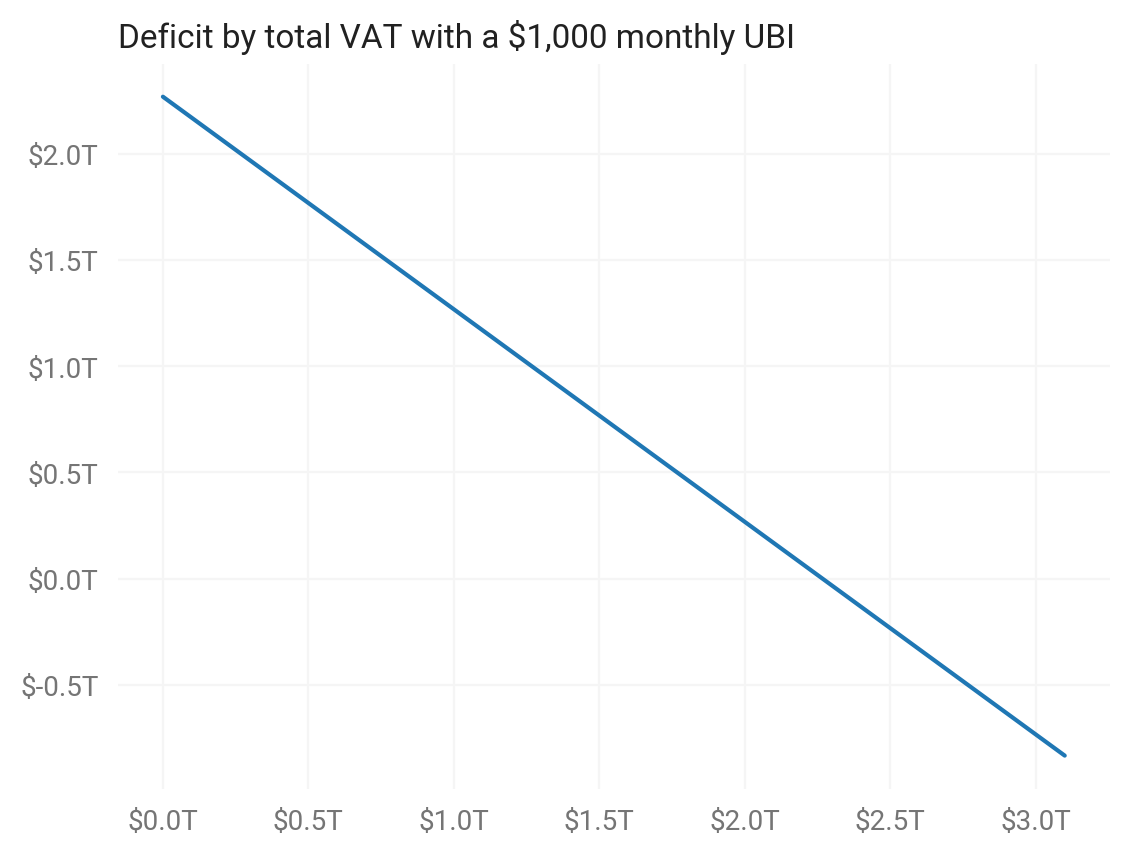

In [42]:
ax = deficits[deficits.ubi == UBI].sort_values('total_vat').plot('total_vat', 'deficit')
plt.title('Deficit by total VAT with a $1,000 monthly UBI', loc='left')
sns.despine(left=True, bottom=True)
ax.get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: '$' + format(x / 1e12) + 'T'))
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: '$' + format(x / 1e12) + 'T'))
ax.grid(color=GRID_COLOR)
ax.legend_.remove()
plt.xlabel('')
plt.show()

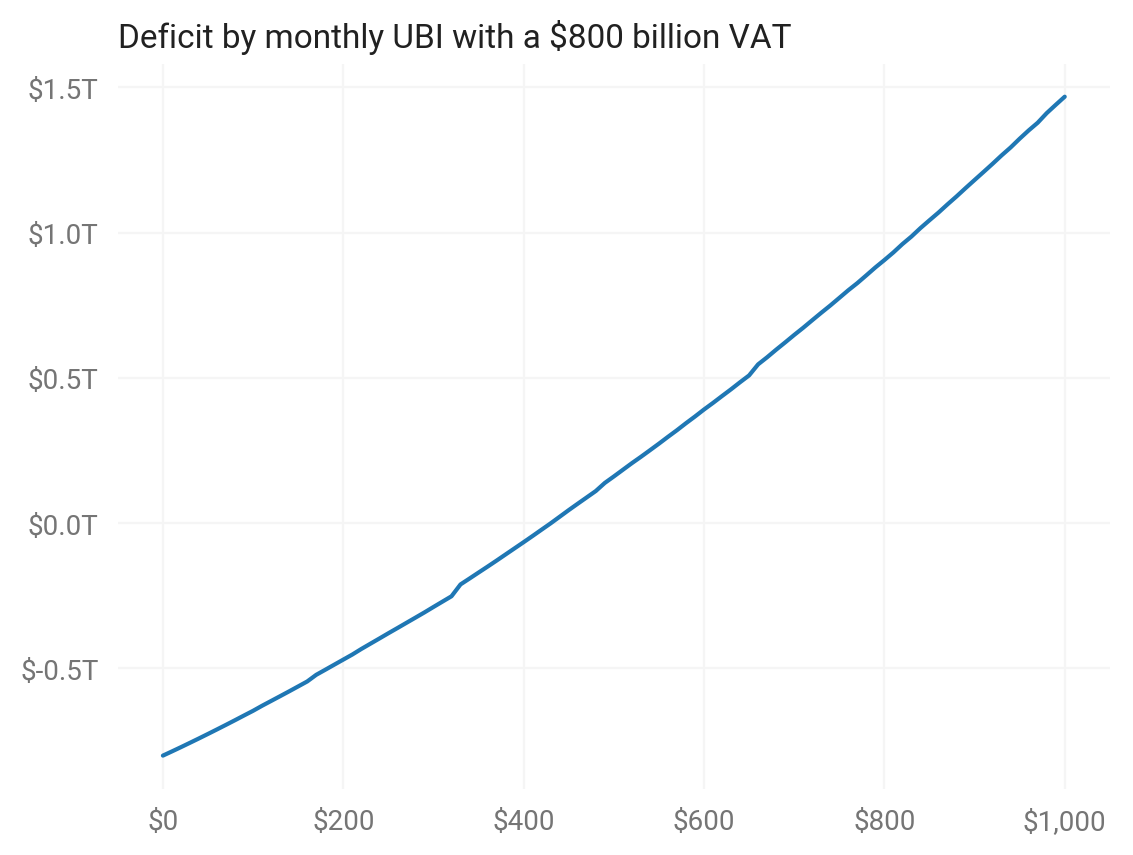

In [43]:
ax = deficits[deficits.total_vat == TOTAL_VAT].drop_duplicates().sort_values('ubi').plot('ubi_monthly', 'deficit')
plt.title('Deficit by monthly UBI with a $800 billion VAT', loc='left')
sns.despine(left=True, bottom=True)
ax.get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: '$' + format(int(x), ',')))
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: '$' + format(x / 1e12) + 'T'))
ax.grid(color=GRID_COLOR)
ax.legend_.remove()
plt.xlabel('')
plt.show()

## Analysis

### Benefit reductions

In [63]:
BEN_NAME = {
    'e02400': 'Social Security',
    'e02300': 'Unemployment',
    'snap_ben': 'SNAP',
    'ssi_ben': 'SSI',
    'tanf_ben': 'TANF',
    'housing_ben': 'Housing assistance',
    'wic_ben': 'WIC',
    'other_ben': 'Other'
}

In [64]:
ben_reduction_l = []
for i in BENS:
    tmp = pd.DataFrame({
        'base': [tch.weighted_sum(base, i)],
        'yang': [tch.weighted_sum(base[base.ubi > 0], i)]
    }, index=[i])
    ben_reduction_l.append(tmp)
ben_reduction = pd.concat(ben_reduction_l)
ben_reduction['ben_name'] = ben_reduction.index.map(BEN_NAME)
ben_reduction['reduction'] = ben_reduction.base - ben_reduction.yang
ben_reduction['pct_reduction'] = ben_reduction.reduction / ben_reduction.base
ben_reduction

,base,yang,ben_name,reduction,pct_reduction
other_ben,2.88e+11,1.30e+11,Other,1.58e+11,0.55
snap_ben,8.76e+10,3.48e+10,SNAP,5.29e+10,0.60
ssi_ben,5.23e+10,5.20e+09,SSI,4.71e+10,0.90
tanf_ben,2.99e+10,1.13e+10,TANF,1.87e+10,0.62
wic_ben,3.71e+09,1.89e+09,WIC,1.82e+09,0.49
housing_ben,3.68e+10,4.13e+09,Housing assistance,3.27e+10,0.89
e02400,1.05e+12,1.73e+11,Social Security,8.82e+11,0.84
e02300,2.13e+10,1.66e+10,Unemployment,4.76e+09,0.22


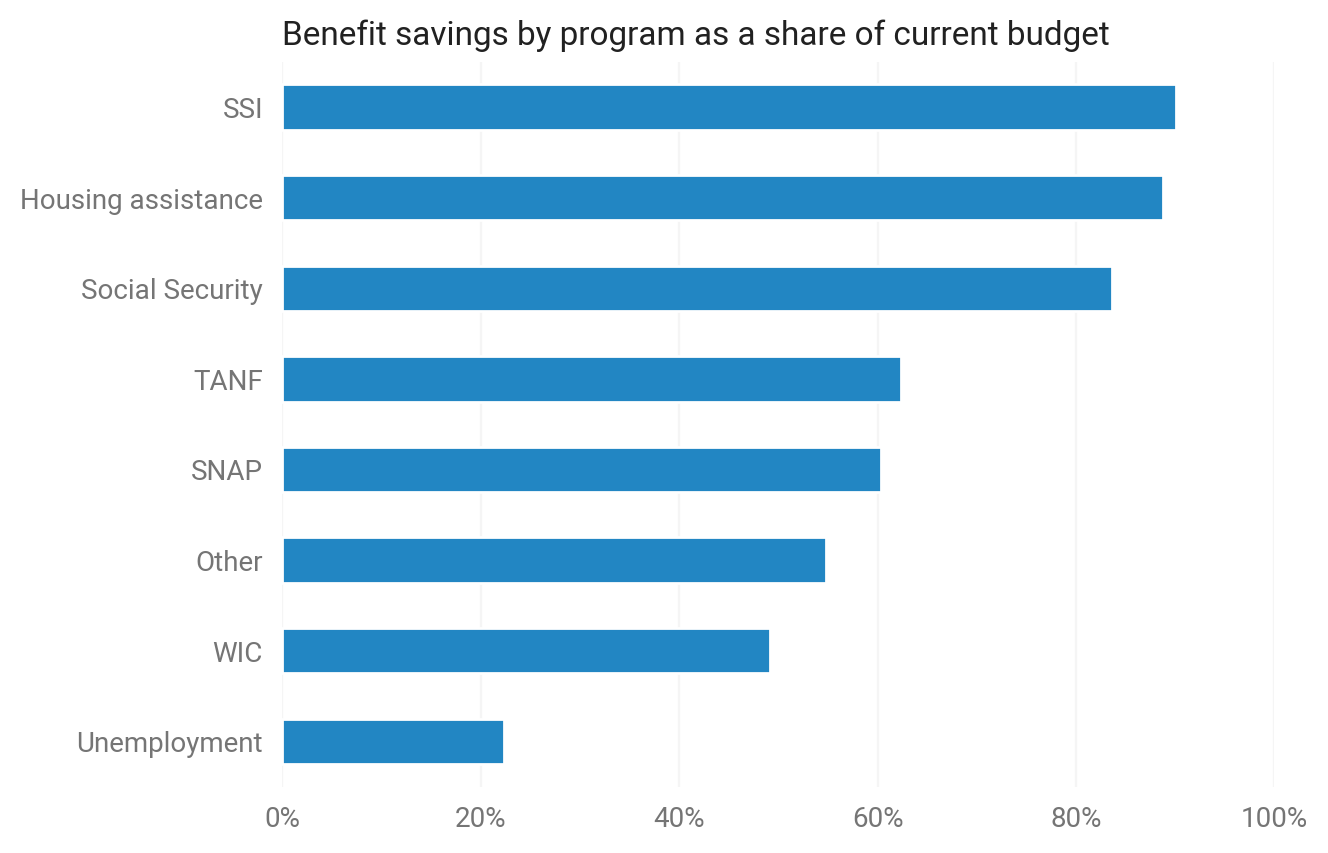

In [65]:
ax = ben_reduction.sort_values('pct_reduction').plot.barh(x='ben_name', y='pct_reduction', color='#2286c3')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '{:.0%}'.format(x)))
plt.title('Benefit savings by program as a share of current budget', loc='left')
ax.grid(color=GRID_COLOR, axis='x')
ax.legend_.remove()
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.show()

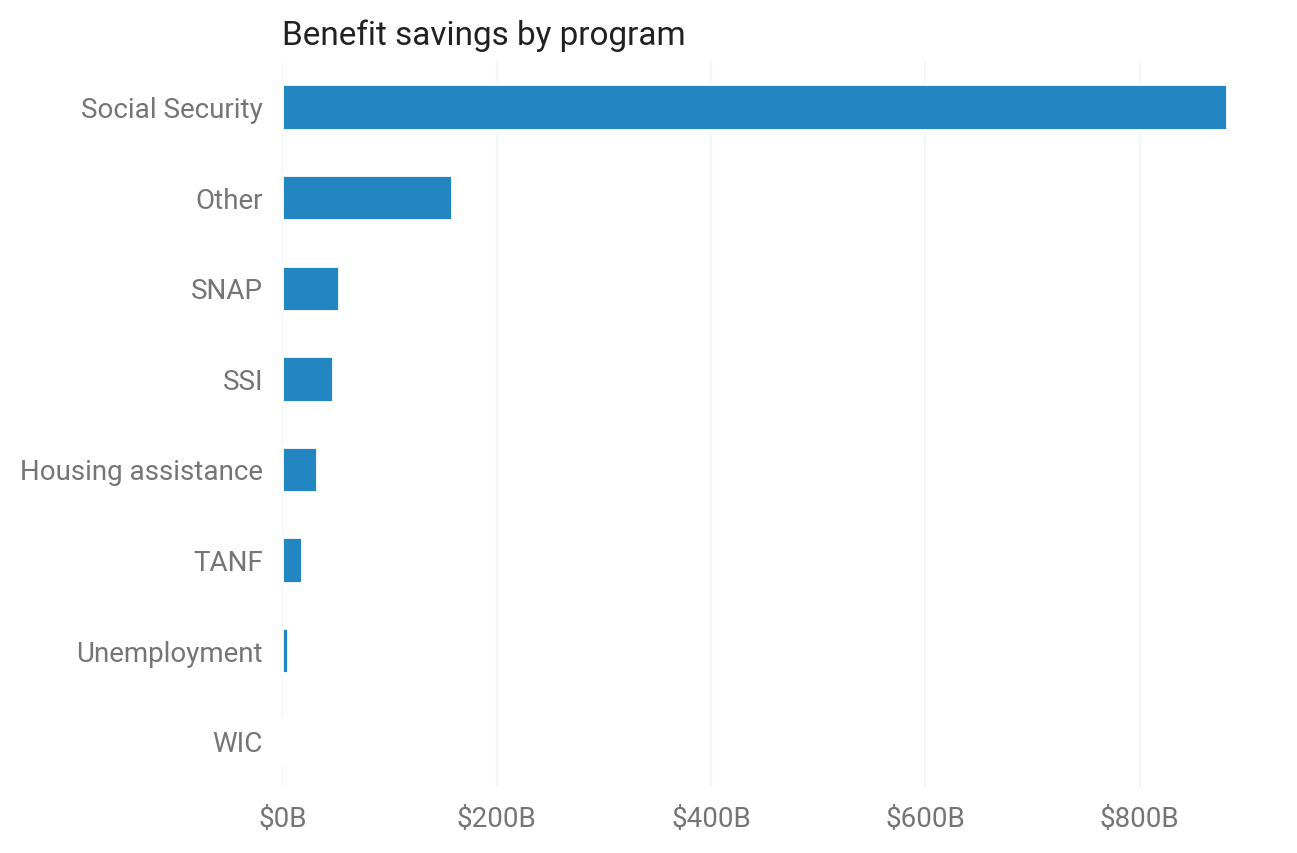

In [66]:
ax = ben_reduction.sort_values('reduction').plot.barh(x='ben_name', y='reduction', color='#2286c3')
# plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '$' + format(int(x / 1e9), ',') + 'B'))
plt.title('Benefit savings by program', loc='left')
ax.grid(color=GRID_COLOR, axis='x')
ax.legend_.remove()
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.show()

In [49]:
base.sort_values('afti_chg', ascending=False).head()

,tanf_ben,aftertax_income,XTOT,other_ben,ssi_ben,e02300,wic_ben,nu18,n21,snap_ben,...,afti_yang_prevat_noneg_quintile,afti_yang_prevat_noneg_quartile,vat_rate_prescale,vat_base,vat,vat_m,afti_yang_prevat_noneg_m,afti_yang,afti_chg,afti_chg_m
RECID,,,,,,,,,,,,,,,,,,,,,
167613,0.0,2935.90,12.0,0.00,0.00,0.00,0.0,0.0,11.0,0.0,...,5,4,0.03,4995.82,8117.46,7.12,128.91,138818.44,135882.54,119.21
206972,0.0,87675.55,8.0,10997.35,5733.59,0.00,0.0,0.0,6.0,0.0,...,5,4,0.03,5877.62,9550.25,10.52,202.23,174125.30,86449.75,95.18
21452,0.0,111172.48,8.0,23440.61,0.00,1776.61,0.0,0.0,7.0,0.0,...,5,4,0.03,6629.52,10771.98,12.16,233.78,196400.50,85228.02,96.17
388397,0.0,0.00,7.0,0.00,0.00,0.00,0.0,0.0,6.0,0.0,...,4,3,0.04,3024.00,4913.55,2.71,46.28,79086.45,79086.45,43.57
201244,0.0,20623.71,7.0,0.00,0.00,494.30,0.0,0.0,7.0,0.0,...,4,3,0.04,3766.45,6119.93,0.66,11.21,98503.78,77880.07,8.35


In [50]:
base.vat_m.sum() / base.afti_yang_prevat_noneg_m.sum()

0.05462699670706919

In [51]:
decile = base.groupby('aftertax_income_decile')['aftertax_income_m', 'afti_chg_m',
                                                'vat_m', 'afti_yang_prevat_noneg_m', 's006'].sum()
decile['afti_chg'] = 1e6 * decile.afti_chg_m / decile.s006
decile['afti_chg_pct'] = decile.afti_chg_m / decile.aftertax_income_m
decile['vat'] = 1e6 * decile.vat_m / decile.s006
decile['vat_pct'] = decile.vat_m / decile.afti_yang_prevat_noneg_m
decile.drop(0, inplace=True)
decile

,aftertax_income_m,afti_chg_m,vat_m,afti_yang_prevat_noneg_m,s006,afti_chg,afti_chg_pct,vat,vat_pct
aftertax_income_decile,,,,,,,,,
1,1.65e+05,184342.78,23441.63,3.73e+05,1.65e+07,11188.10,1.12,1422.72,0.06
2,3.87e+05,176640.86,36861.10,6.00e+05,1.65e+07,10688.46,0.46,2230.45,0.06
3,5.18e+05,141208.82,41756.75,7.01e+05,1.65e+07,8544.76,0.27,2526.76,0.06
4,6.45e+05,143455.52,49257.07,8.37e+05,1.65e+07,8680.26,0.22,2980.47,0.06
5,7.93e+05,156160.03,58938.56,1.01e+06,1.65e+07,9449.44,0.20,3566.44,0.06
6,9.76e+05,144540.70,69614.05,1.19e+06,1.65e+07,8745.27,0.15,4211.92,0.06
7,1.21e+06,148450.04,84099.55,1.44e+06,1.65e+07,8982.88,0.12,5088.96,0.06
8,1.52e+06,149871.06,102452.61,1.77e+06,1.65e+07,9068.46,0.10,6199.25,0.06
9,2.03e+06,137589.55,127324.58,2.30e+06,1.65e+07,8325.40,0.07,7704.28,0.06


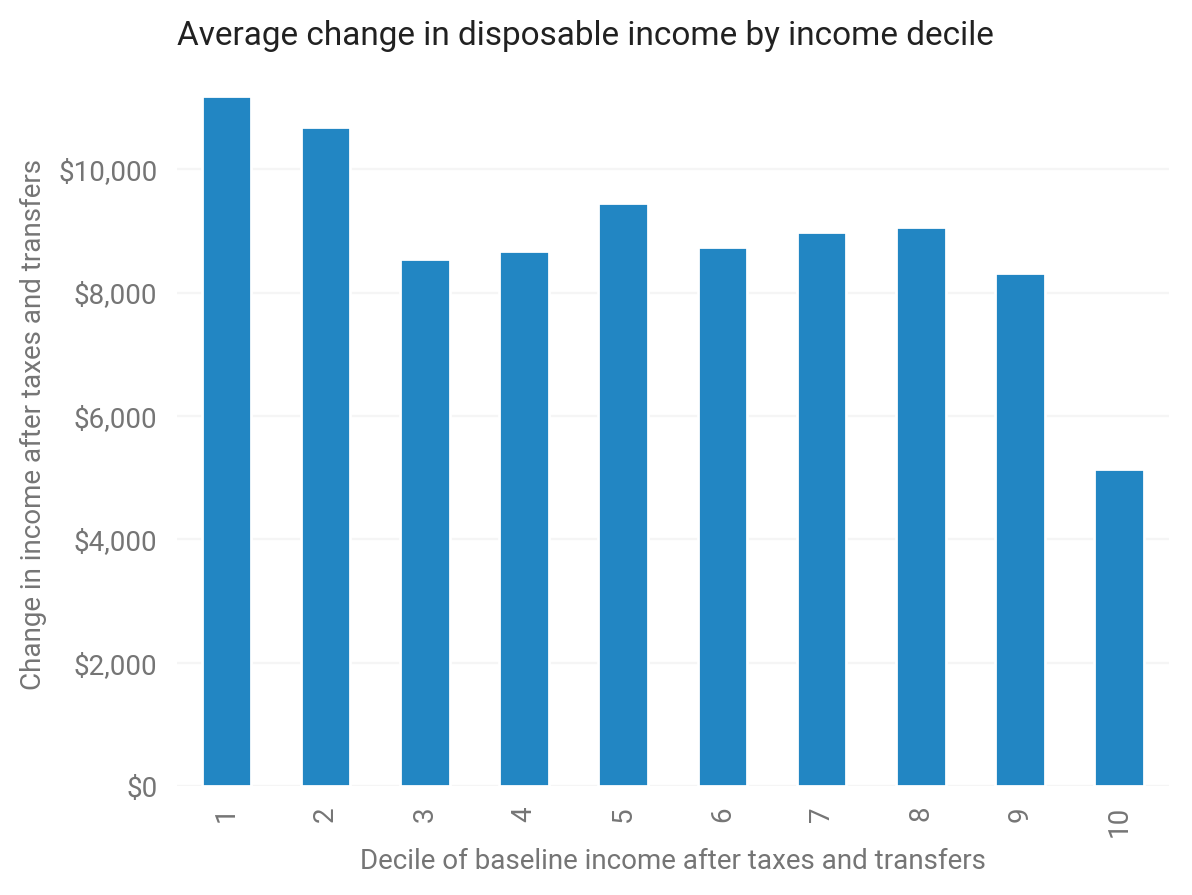

In [52]:
ax = decile.afti_chg.plot.bar(color='#2286c3')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '$' + format(int(x), ',')))
plt.title('Average change in disposable income by income decile', loc='left')
ax.grid(color=GRID_COLOR, axis='y')
plt.ylabel('Change in income after taxes and transfers')
plt.xlabel('Decile of baseline income after taxes and transfers')
sns.despine(left=True, bottom=True)
plt.show()

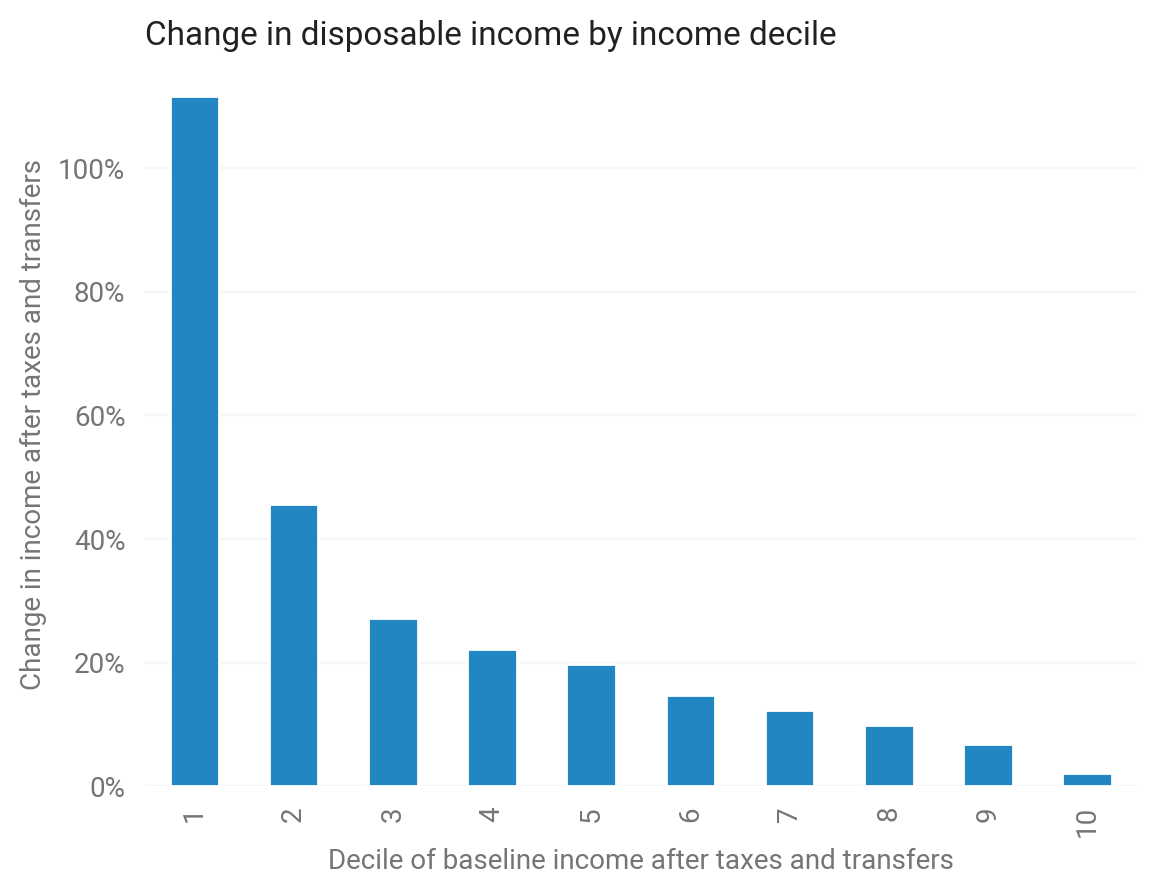

In [53]:
ax = decile.afti_chg_pct.plot.bar(color='#2286c3')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '{:.0%}'.format(x)))
plt.title('Change in disposable income by income decile', loc='left')
ax.grid(color=GRID_COLOR, axis='y')
plt.ylabel('Change in income after taxes and transfers')
plt.xlabel('Decile of baseline income after taxes and transfers')
sns.despine(left=True, bottom=True)
plt.show()

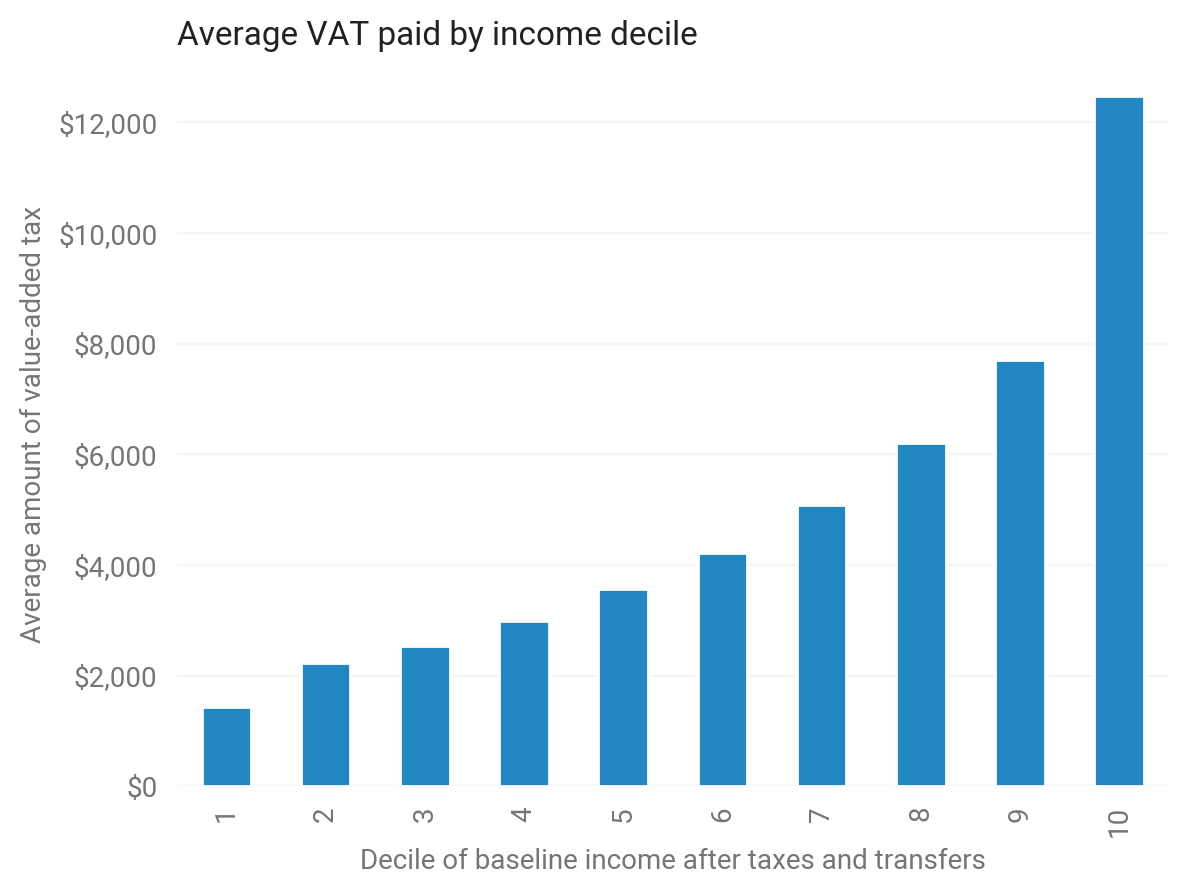

In [54]:
ax = decile.vat.plot.bar(color='#2286c3')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '$' + format(int(x), ',')))
plt.title('Average VAT paid by income decile', loc='left')
ax.grid(color=GRID_COLOR, axis='y')
plt.ylabel('Average amount of value-added tax')
plt.xlabel('Decile of baseline income after taxes and transfers')
sns.despine(left=True, bottom=True)
plt.show()

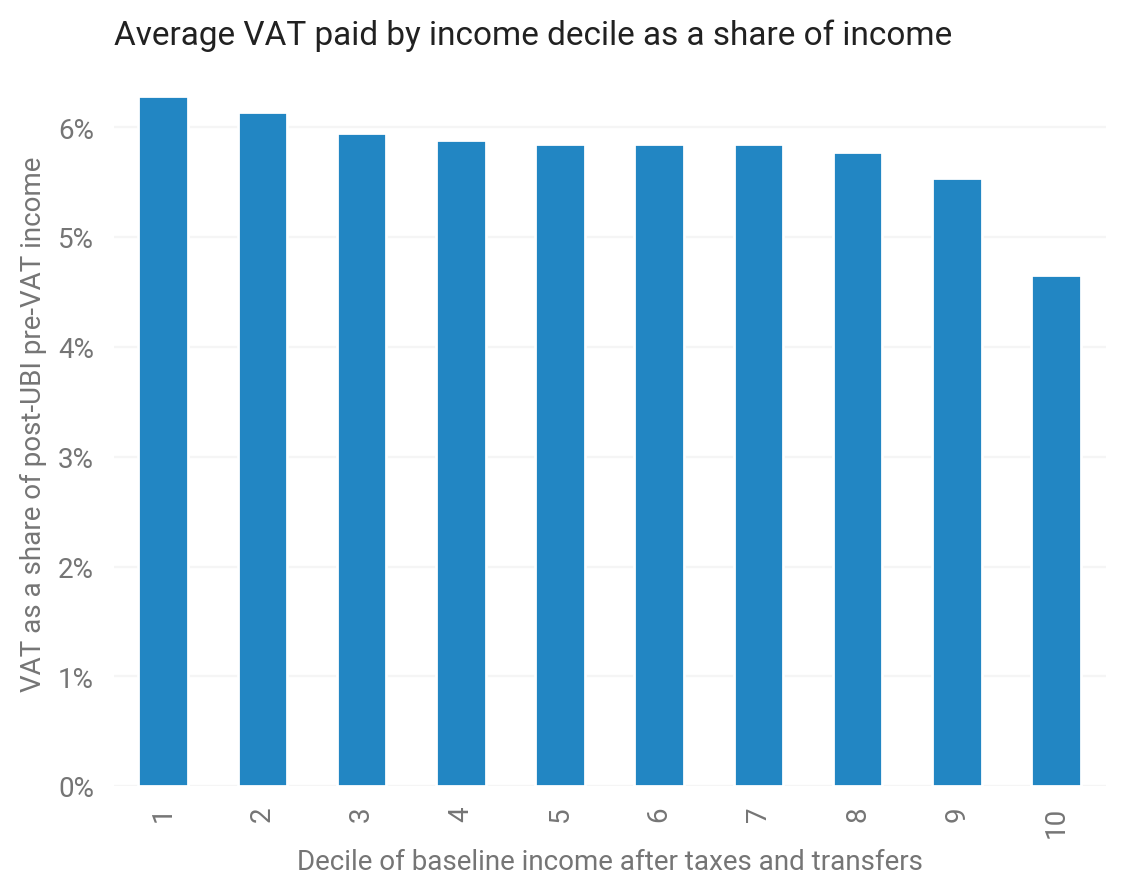

In [55]:
ax = decile.vat_pct.plot.bar(color='#2286c3')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '{:.0%}'.format(x)))
plt.title('Average VAT paid by income decile as a share of income', loc='left')
ax.grid(color=GRID_COLOR, axis='y')
plt.ylabel('VAT as a share of post-UBI pre-VAT income')
plt.xlabel('Decile of baseline income after taxes and transfers')
sns.despine(left=True, bottom=True)
plt.show()

In [56]:
ventile = base.groupby('aftertax_income_ventile')['aftertax_income_m', 'afti_chg_m', 's006'].sum()
ventile['afti_chg'] = 1e6 * ventile.afti_chg_m / ventile.s006
ventile['afti_chg_pct'] = ventile.afti_chg_m / ventile.aftertax_income_m
ventile.drop(0, inplace=True)
ventile

,aftertax_income_m,afti_chg_m,s006,afti_chg,afti_chg_pct
aftertax_income_ventile,,,,,
5,3.87e+04,93439.23,8.21e+06,11377.02,2.42e+00
10,1.26e+05,90903.55,8.26e+06,11000.34,7.19e-01
15,1.75e+05,92415.61,8.26e+06,11183.95,5.30e-01
20,2.12e+05,84225.25,8.26e+06,10192.95,3.97e-01
25,2.44e+05,72156.62,8.26e+06,8732.05,2.95e-01
30,2.74e+05,69052.21,8.26e+06,8357.45,2.52e-01
35,3.06e+05,69807.04,8.26e+06,8446.97,2.28e-01
40,3.39e+05,73648.48,8.26e+06,8913.60,2.17e-01
45,3.76e+05,78515.28,8.26e+06,9501.57,2.09e-01


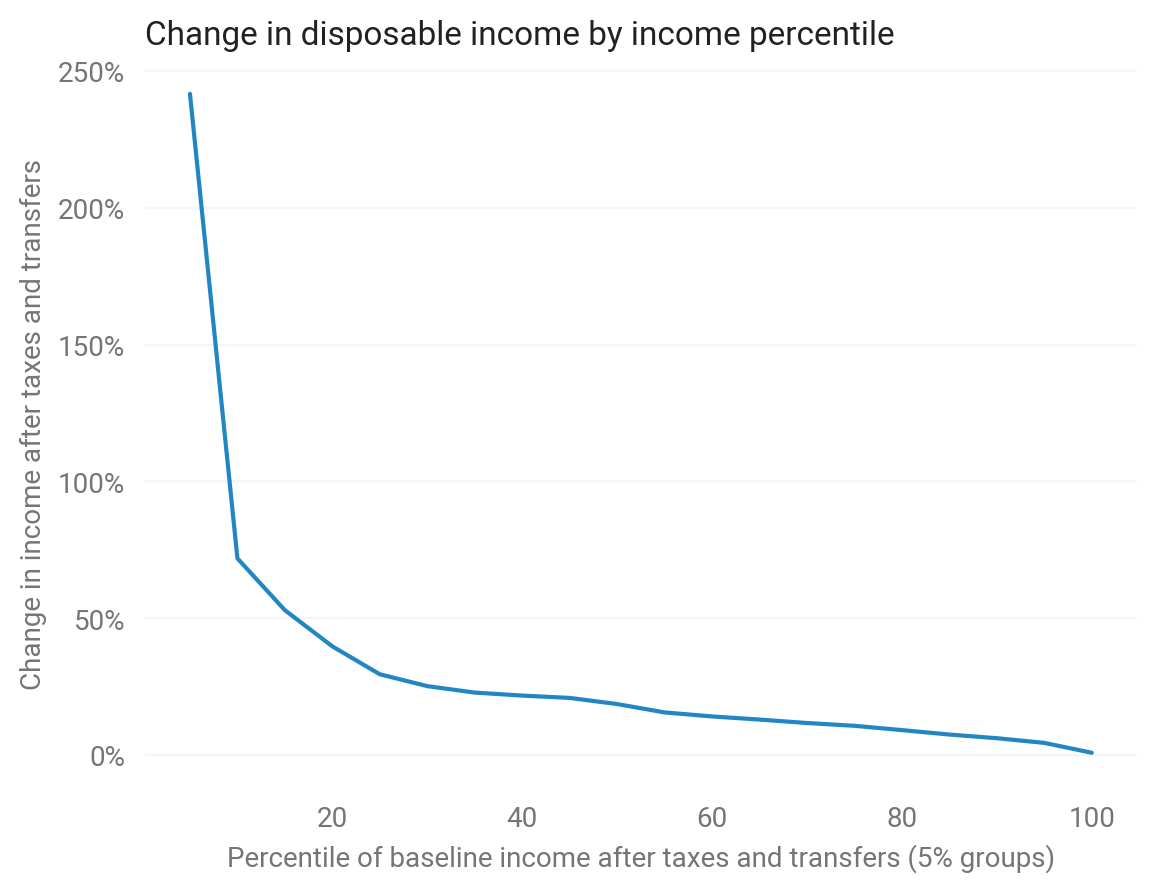

In [70]:
ax = ventile.afti_chg_pct.plot(color='#2286c3')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '{:.0%}'.format(x)))
plt.title('Change in disposable income by income percentile', loc='left')
ax.grid(color=GRID_COLOR, axis='y')
plt.xlabel('Percentile of baseline income after taxes and transfers (5% groups)')
plt.ylabel('Change in income after taxes and transfers')
sns.despine(left=True, bottom=True)
plt.show()

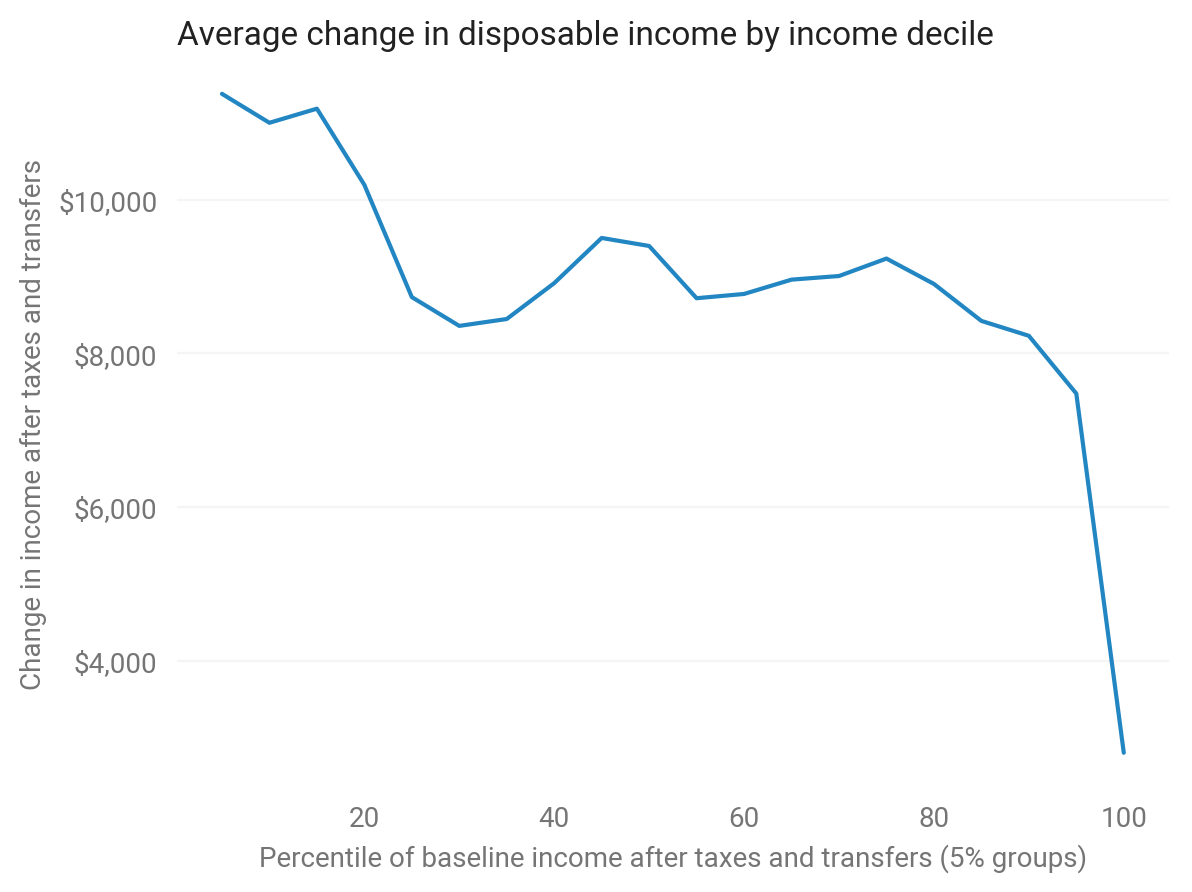

In [71]:
ax = ventile.afti_chg.plot(color='#2286c3')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '$' + format(int(x), ',')))
plt.title('Average change in disposable income by income decile', loc='left')
ax.grid(color=GRID_COLOR, axis='y')
plt.xlabel('Percentile of baseline income after taxes and transfers (5% groups)')
plt.ylabel('Change in income after taxes and transfers')
sns.despine(left=True, bottom=True)
plt.show()

### Poverty

In [72]:
base['fpl'] = tch.fpl(base.XTOT)
base['fpl_base_m'] = base.XTOT_m * (base.aftertax_income < base.fpl)
base['fpl_yang_m'] = base.XTOT_m * (base.afti_yang < base.fpl)

In [73]:
base.fpl_base_m.sum() / base.XTOT_m.sum()

0.05053883636467063

In [74]:
base.fpl_yang_m.sum() / base.XTOT_m.sum()

0.010580615386463163

In [75]:
base[base.fpl_base_m < base.fpl_yang_m].adults.describe()

count    214.00
mean       0.34
std        0.49
min        0.00
25%        0.00
50%        0.00
75%        1.00
max        2.00
Name: adults, dtype: float64